In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import hvplot.pandas  
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Preprocessing_Loan_CSV.csv')
df1

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_status_binary,credit_history_length
0,2500,2500,2500.0,36.0,13.56,84.92,2,10,10.0,RENT,...,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,0,17.0
1,30000,30000,30000.0,60.0,18.94,777.23,3,16,10.0,MORTGAGE,...,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,0,31.0
2,5000,5000,5000.0,36.0,17.97,180.69,3,15,6.0,MORTGAGE,...,100.0,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,0,7.0
3,4000,4000,4000.0,36.0,18.94,146.51,3,16,10.0,MORTGAGE,...,100.0,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,0,12.0
4,30000,30000,30000.0,60.0,16.14,731.78,2,13,10.0,MORTGAGE,...,92.3,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260663,12000,12000,12000.0,60.0,14.08,279.72,2,12,10.0,MORTGAGE,...,100.0,66.7,0.0,0.0,73948.0,45212.0,6200.0,49448.0,0,13.0
2260664,12000,12000,12000.0,60.0,25.82,358.01,4,23,0.0,MORTGAGE,...,76.9,50.0,0.0,0.0,382275.0,12928.0,11400.0,12125.0,0,14.0
2260665,10000,10000,10000.0,36.0,11.99,332.10,1,9,10.0,OWN,...,100.0,100.0,0.0,0.0,203417.0,36448.0,2000.0,29317.0,0,22.0
2260666,12000,12000,12000.0,60.0,21.45,327.69,3,19,6.0,RENT,...,88.2,0.0,0.0,0.0,118975.0,65238.0,22000.0,81975.0,0,14.0


In [38]:
dfc1= df1.copy()

In [39]:
df1.shape

(2260668, 74)

4. Feature Analysis


In [ ]:
#numerical columns
numerical_cols = df1.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target column
if 'loan_status_binary' in numerical_cols:
    numerical_cols.remove('loan_status_binary')

print(f"Number of numerical features: {len(numerical_cols)}")
print("Numerical columns:")
print(numerical_cols[:10], "..." if len(numerical_cols) > 10 else "")

# correlation with target
if 'loan_status_binary' in df1.columns:
    # Correlations
    target_corr = df1[numerical_cols + ['loan_status_binary']].corr()['loan_status_binary']

    # sorted correlation table
    corr_table = pd.DataFrame({
        'Feature': target_corr.index,
        'Correlation': target_corr.values
    })

    corr_table = corr_table[corr_table['Feature'] != 'loan_status_binary']

    # sorting by absolute correlation value (descending)
    corr_table['Abs_Correlation'] = corr_table['Correlation'].abs()
    corr_table = corr_table.sort_values('Abs_Correlation', ascending=False).drop('Abs_Correlation', axis=1)

    # displaying
    pd.set_option('display.max_rows', None)
    print("\nCorrelation with loan_status_binary (sorted by strength):")
    display(corr_table)
    pd.reset_option('display.max_rows')
else:
    print("Error: 'loan_status_binary' column not found in DataFrame")

Number of numerical features: 63
Numerical columns:
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'annual_inc'] ...

Correlation with loan_status_binary (sorted by strength):


,Feature,Correlation
7,sub_grade,0.233236
6,grade,0.229232
18,total_rec_prncp,-0.223022
4,int_rate,0.209173
21,last_pymnt_amnt,-0.187750
20,total_rec_late_fee,0.143870
27,acc_open_past_24mths,0.092979
3,term,0.091060
12,inq_last_6mths,0.085547
53,num_tl_op_past_12m,0.082232


In [41]:
#dropping columns with corelation lesser than 0.01
low_corr_cols_to_drop = [
    'collections_12_mths_ex_med', 'emp_length', 'pct_tl_nvr_dlq',
    'acc_now_delinq', 'num_tl_30dpd', 'chargeoff_within_12_mths',
    'num_bc_sats', 'delinq_amnt', 'num_tl_120dpd_2m', 'tot_coll_amt'
]

df1.drop(columns=[col for col in low_corr_cols_to_drop if col in df1.columns], inplace=True)

In [ ]:
# selecting retained numerical columns 
numerical_cols = df1.select_dtypes(include=['int64', 'float64']).columns.tolist()

# summary stats
num_summary = df1[numerical_cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T
num_summary['skew'] = df1[numerical_cols].skew()
num_summary['kurt'] = df1[numerical_cols].kurt()

pd.set_option('display.max_rows', None)
display(num_summary)
pd.reset_option('display.max_rows')


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,skew,kurt
loan_amnt,2260668.0,15046.931228,9190.245488,5.000000e+02,1525.0000,3250.00,8000.00,12900.000,20000.000,35000.0000,40000.0000,4.000000e+04,0.777782,-0.119439
funded_amnt,2260668.0,15041.664057,9188.413022,5.000000e+02,1516.7500,3250.00,8000.00,12875.000,20000.000,35000.0000,40000.0000,4.000000e+04,0.778779,-0.117009
funded_amnt_inv,2260668.0,15023.437624,9192.331807,0.000000e+00,1500.0000,3200.00,8000.00,12800.000,20000.000,35000.0000,40000.0000,4.000000e+04,0.778254,-0.116682
term,2260668.0,42.910319,10.867161,3.600000e+01,36.0000,36.00,36.00,36.000,60.000,60.0000,60.0000,6.000000e+01,0.936709,-1.122577
int_rate,2260668.0,13.092913,4.832114,5.310000e+00,5.3200,6.49,9.49,12.620,15.990,22.1500,26.7700,3.099000e+01,0.768074,0.594048
installment,2260668.0,445.807646,267.173725,4.930000e+00,53.4600,110.43,251.65,377.990,593.320,984.4700,1238.4600,1.719830e+03,1.001778,0.689871
grade,2260668.0,1.663888,1.258087,0.000000e+00,0.0000,0.00,1.00,2.000,2.000,4.0000,5.0000,6.000000e+00,0.640420,0.179915
sub_grade,2260668.0,10.279832,6.300372,0.000000e+00,0.0000,1.00,6.00,10.000,14.000,22.0000,28.0000,3.400000e+01,0.595141,0.190439
annual_inc,2260668.0,77992.405698,112696.101198,0.000000e+00,16800.0000,27600.00,46000.00,65000.000,93000.000,160000.0000,270000.0000,1.100000e+08,493.886509,439002.415385
dti,2260668.0,18.823452,14.177986,-1.000000e+00,1.7200,4.94,11.90,17.840,24.480,33.8800,42.7000,9.990000e+02,29.212909,1756.586347


In [43]:
categorical_cols = df1.select_dtypes(include=['object','string']).columns.tolist()
print(categorical_cols)

['home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'application_type']


In [ ]:
print(f"Number of categorical features: {len(categorical_cols)}")
print("Categorical columns:")
print(categorical_cols)

# unique values in each categorical column
cat_uniques = {col: df1[col].nunique() for col in categorical_cols}
cat_uniques = pd.Series(cat_uniques).sort_values(ascending=False)

print("\nNumber of unique values in each categorical column:")
display(cat_uniques)

# frequency distribution for key categorical variables
key_cat_cols = ['home_ownership', 'verification_status', 'purpose', 'addr_state','initial_list_status','application_type']
key_cat_cols = [col for col in key_cat_cols if col in df1.columns]

for col in key_cat_cols:
    print(f"\nFrequency distribution of {col}:")
    display(df1[col].value_counts().head(10))
    print(f"Number of unique values: {df1[col].nunique()}")


Number of categorical features: 10
Categorical columns:
['home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'application_type']

Number of unique values in each categorical column:


,0
zip_code,956
earliest_cr_line,754
issue_d,139
addr_state,51
purpose,14
loan_status,9
home_ownership,6
verification_status,3
initial_list_status,2
application_type,2



Frequency distribution of home_ownership:


,count
home_ownership,
MORTGAGE,1111450
RENT,894929
OWN,253057
ANY,996
OTHER,182
NONE,54


Number of unique values: 6

Frequency distribution of verification_status:


,count
verification_status,
Source Verified,886231
Not Verified,744806
Verified,629631


Number of unique values: 3

Frequency distribution of purpose:


,count
purpose,
debt_consolidation,1277877
credit_card,516971
home_improvement,150457
other,139440
major_purchase,50445
medical,27488
small_business,24689
car,24013
vacation,15525


Number of unique values: 14

Frequency distribution of addr_state:


,count
addr_state,
CA,314533
NY,186389
TX,186335
FL,161991
IL,91173
NJ,83132
PA,76939
OH,75132
GA,74196


Number of unique values: 51

Frequency distribution of initial_list_status:


,count
initial_list_status,
w,1535467
f,725201


Number of unique values: 2

Frequency distribution of application_type:


,count
application_type,
Individual,2139958
Joint App,120710


Number of unique values: 2


In [45]:
df1.drop(columns=['zip_code', 'earliest_cr_line', 'issue_d', 'loan_status'], inplace=True)
from sklearn.preprocessing import LabelEncoder

label_cols = ['addr_state', 'purpose', 'home_ownership',
              'verification_status', 'initial_list_status', 'application_type']

le = LabelEncoder()
for col in label_cols:
    if col in df1.columns:
        df1[col] = le.fit_transform(df1[col])


In [ ]:
numerical_cols = df1.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'loan_status_binary' in numerical_cols:
    numerical_cols.remove('loan_status_binary')

print(f"Number of numerical features: {len(numerical_cols)}")
print("Numerical columns:")
print(numerical_cols[:10], "..." if len(numerical_cols) > 10 else "")

# calculate correlation with target
if 'loan_status_binary' in df1.columns:
    # Calculate correlations
    target_corr = df1[numerical_cols + ['loan_status_binary']].corr()['loan_status_binary']

    # correlation table
    corr_table = pd.DataFrame({
        'Feature': target_corr.index,
        'Correlation': target_corr.values
    })

    corr_table = corr_table[corr_table['Feature'] != 'loan_status_binary']

    # Sorting by absolute correlation value (descending)
    corr_table['Abs_Correlation'] = corr_table['Correlation'].abs()
    corr_table = corr_table.sort_values('Abs_Correlation', ascending=False).drop('Abs_Correlation', axis=1)

    # Display
    pd.set_option('display.max_rows', None)
    print("\nCorrelation with loan_status_binary (sorted by strength):")
    display(corr_table)
    pd.reset_option('display.max_rows')
else:
    print("Error: 'loan_status_binary' column not found in DataFrame")

Number of numerical features: 59
Numerical columns:
['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'home_ownership', 'annual_inc'] ...

Correlation with loan_status_binary (sorted by strength):


,Feature,Correlation
7,sub_grade,0.233236
6,grade,0.229232
22,total_rec_prncp,-0.223022
4,int_rate,0.209173
25,last_pymnt_amnt,-0.187750
24,total_rec_late_fee,0.143870
10,verification_status,0.095328
29,acc_open_past_24mths,0.092979
3,term,0.091060
15,inq_last_6mths,0.085547


In [47]:
df1.drop(columns=['addr_state'], inplace=True)


In [48]:
df1.shape

(2260668, 59)

5. Some Graph Visualizations

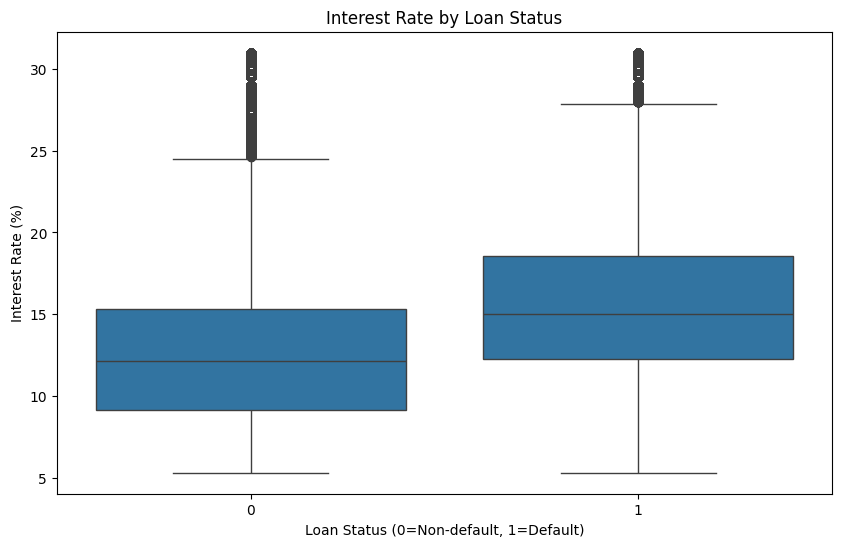

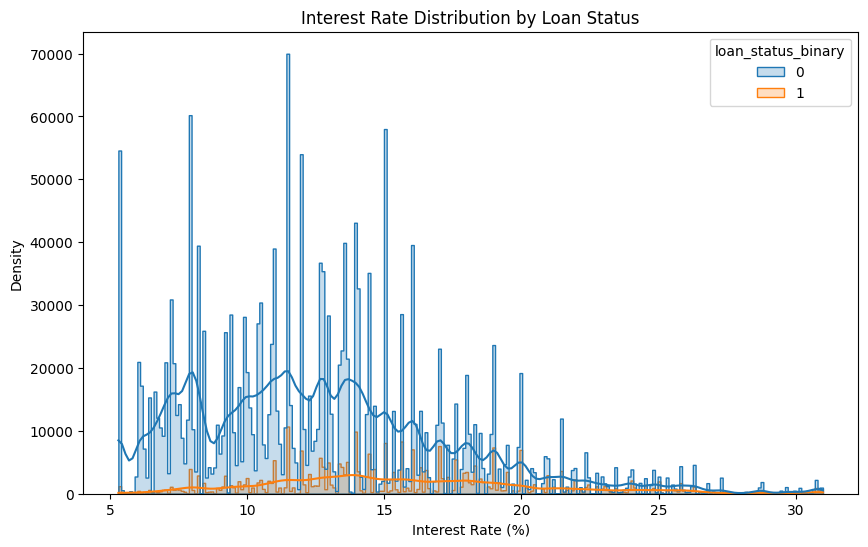

In [49]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status_binary', y='int_rate', data=df1)
plt.title('Interest Rate by Loan Status')
plt.xlabel('Loan Status (0=Non-default, 1=Default)')
plt.ylabel('Interest Rate (%)')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=df1, x='int_rate', hue='loan_status_binary', kde=True, element='step', common_norm=False)
plt.title('Interest Rate Distribution by Loan Status')
plt.xlabel('Interest Rate (%)')
plt.ylabel('Density')
plt.show()


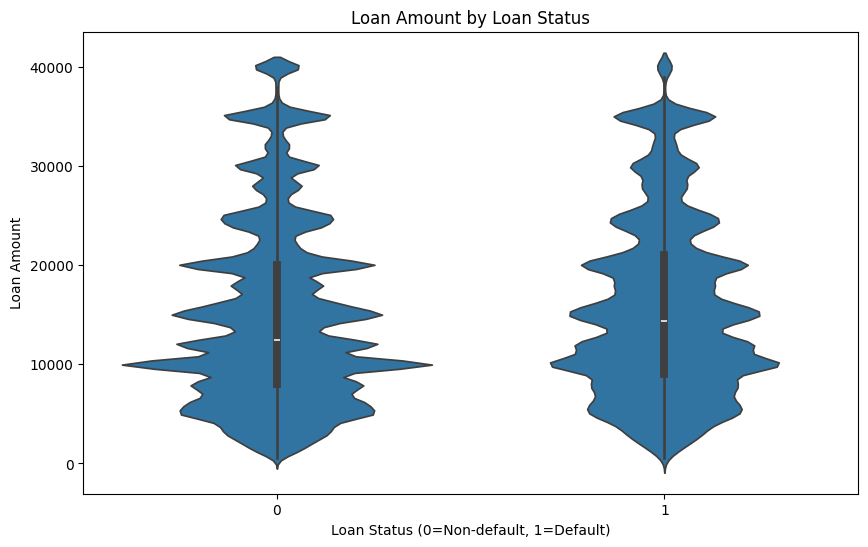

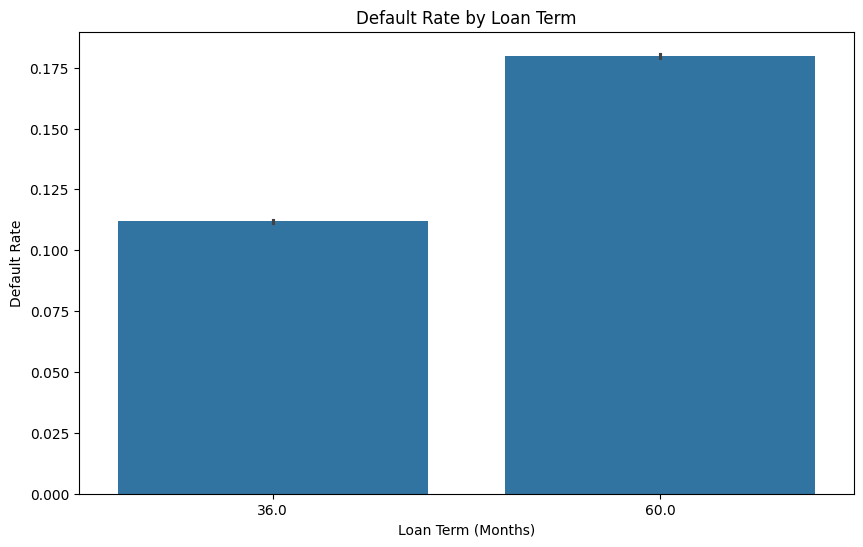

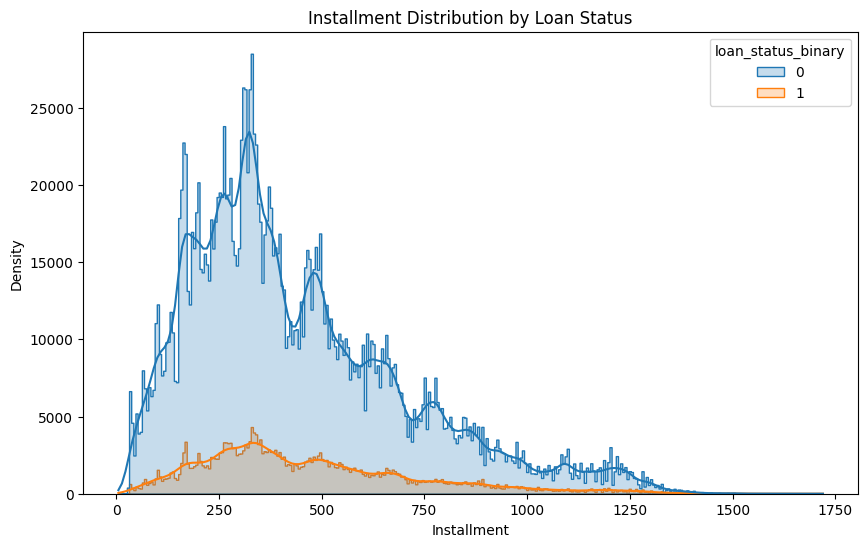

In [50]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='loan_status_binary', y='loan_amnt', data=df1)
plt.title('Loan Amount by Loan Status')
plt.xlabel('Loan Status (0=Non-default, 1=Default)')
plt.ylabel('Loan Amount')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='term', y='loan_status_binary', data=df1)
plt.title('Default Rate by Loan Term')
plt.xlabel('Loan Term (Months)')
plt.ylabel('Default Rate')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=df1, x='installment', hue='loan_status_binary', kde=True, element='step', common_norm=False)
plt.title('Installment Distribution by Loan Status')
plt.xlabel('Installment')
plt.ylabel('Density')
plt.show()


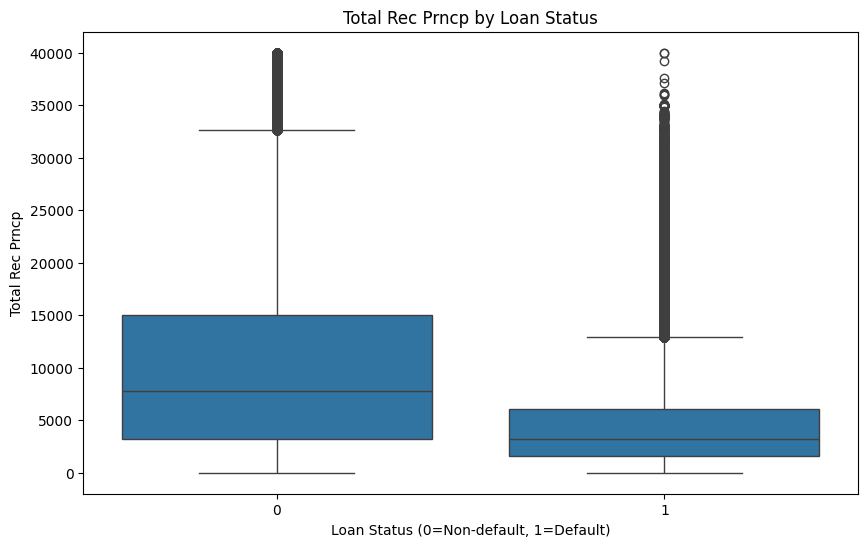

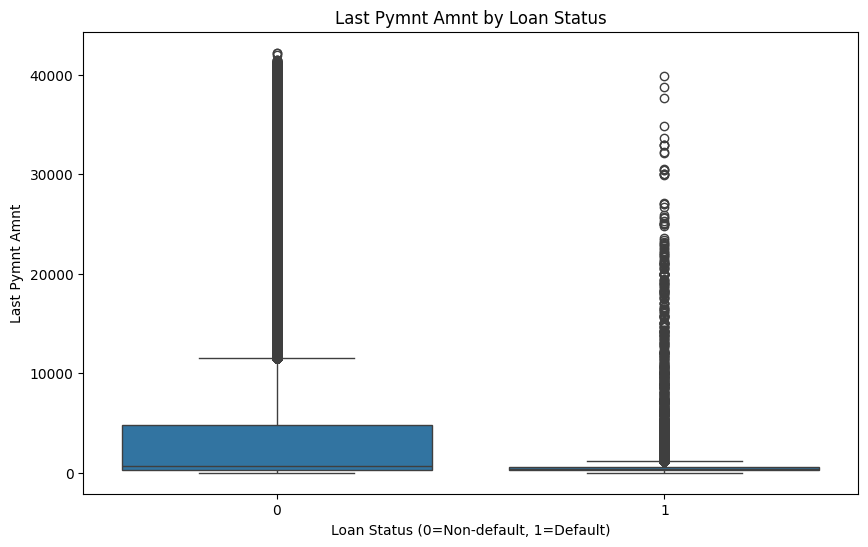

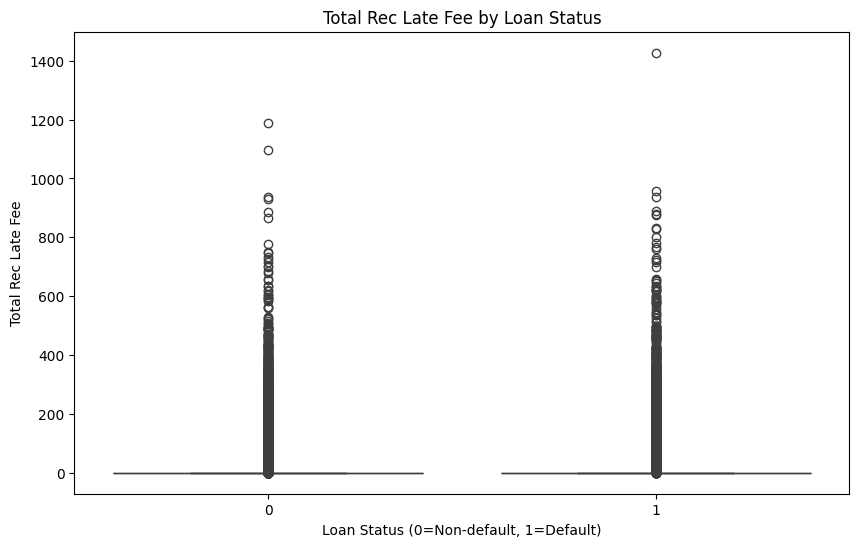

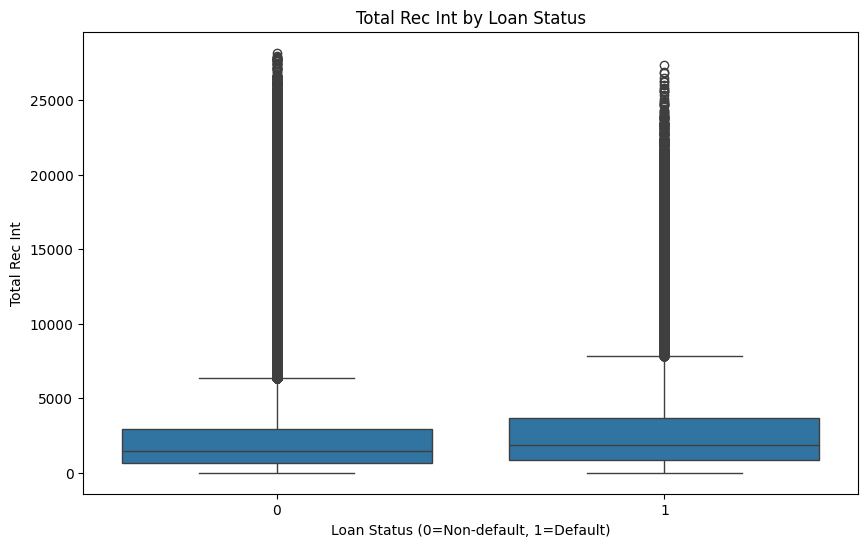

In [51]:
for col in ['total_rec_prncp', 'last_pymnt_amnt', 'total_rec_late_fee', 'total_rec_int']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='loan_status_binary', y=col, data=df1)
    plt.title(f'{col.replace("_", " ").title()} by Loan Status')
    plt.xlabel('Loan Status (0=Non-default, 1=Default)')
    plt.ylabel(col.replace("_", " ").title())
    plt.show()


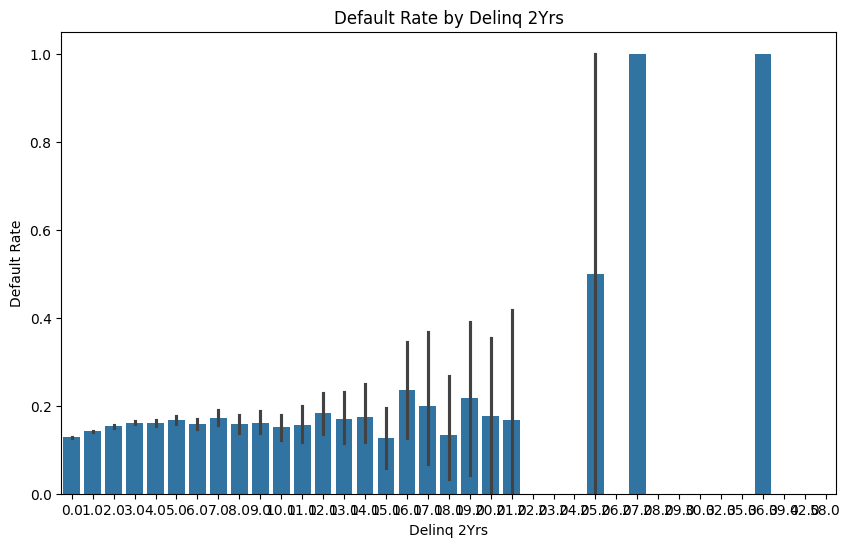

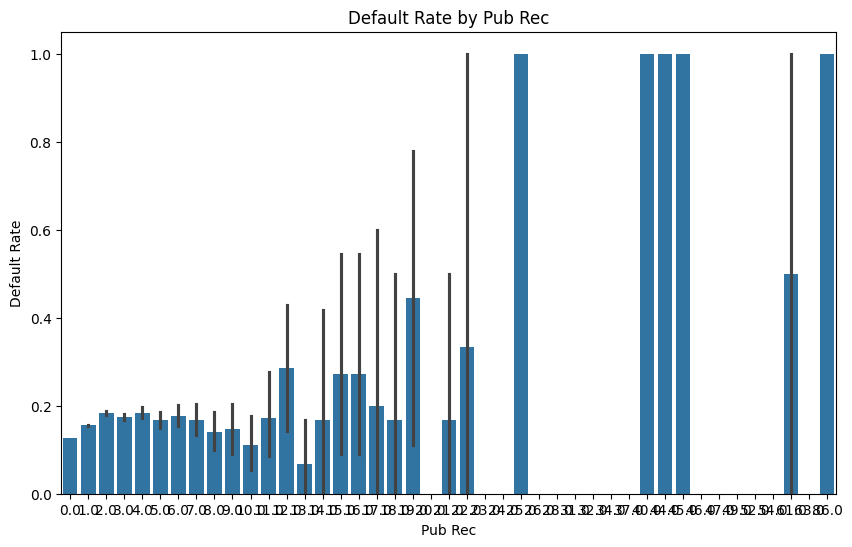

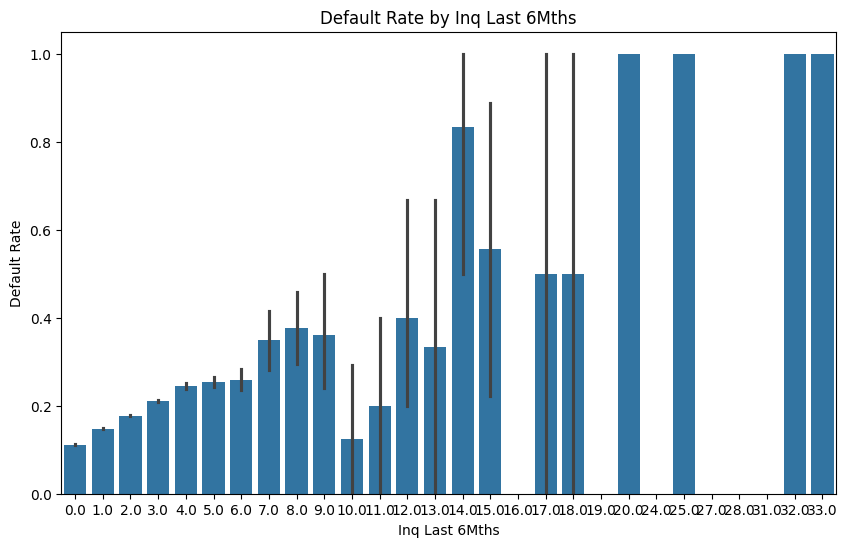

In [52]:
for col in ['delinq_2yrs', 'pub_rec', 'inq_last_6mths']:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=col, y='loan_status_binary', data=df1)
    plt.title(f'Default Rate by {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Default Rate')
    plt.show()


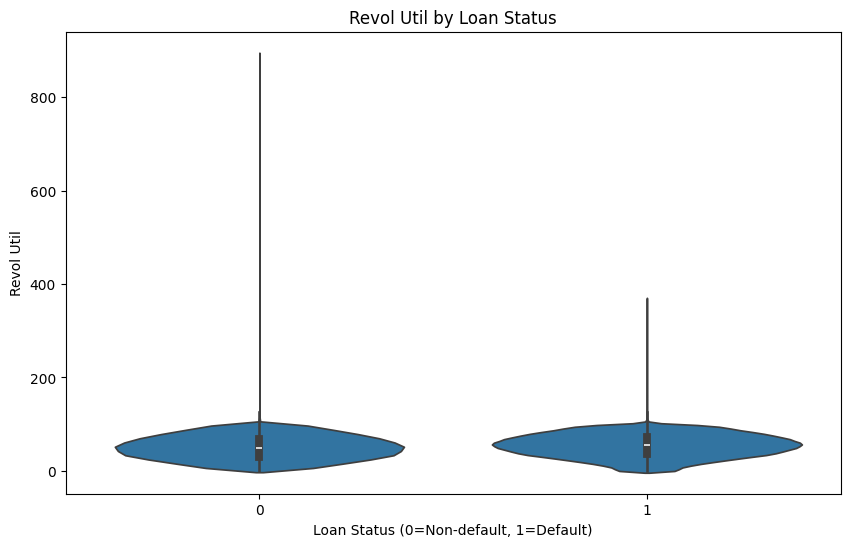

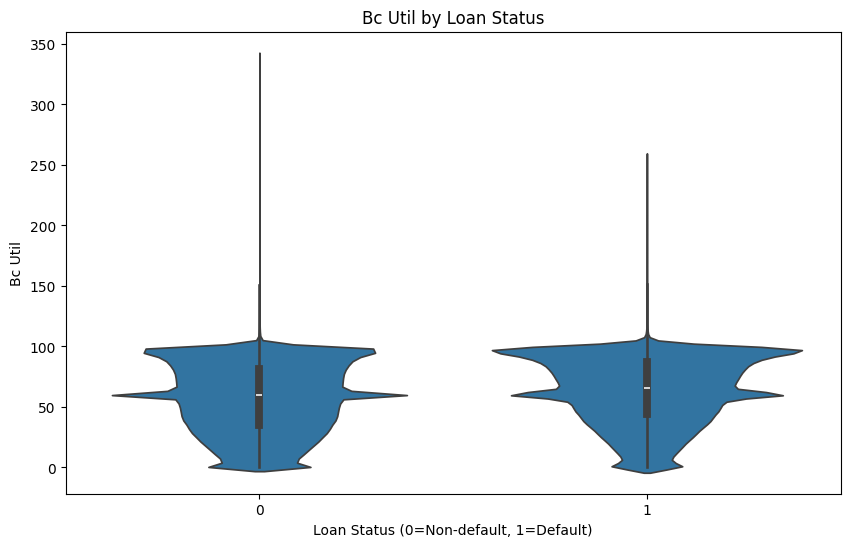

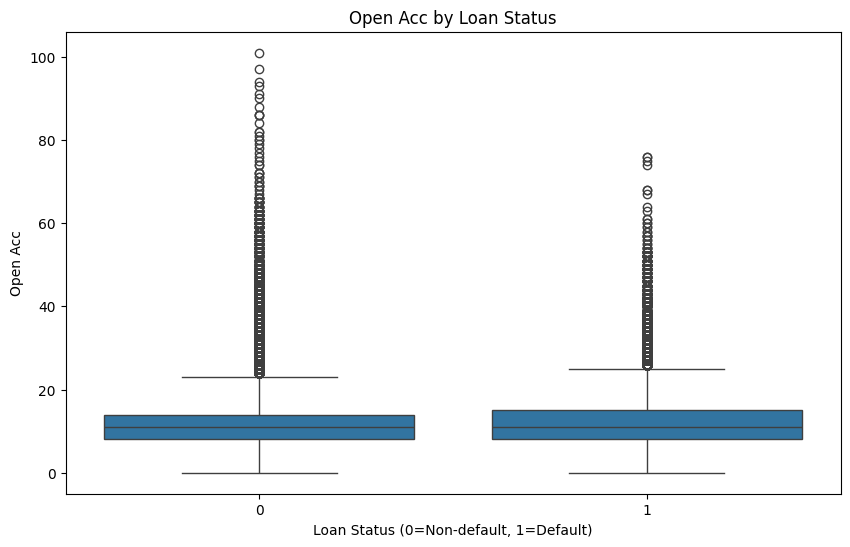

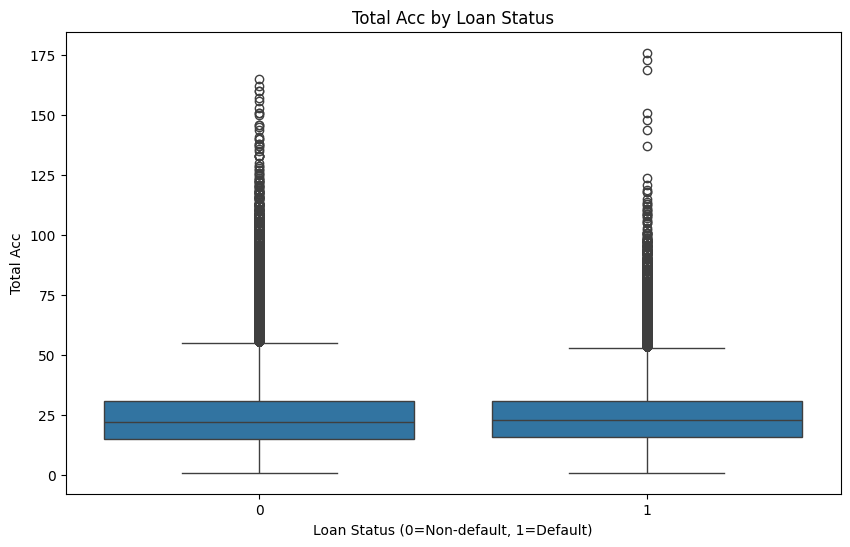

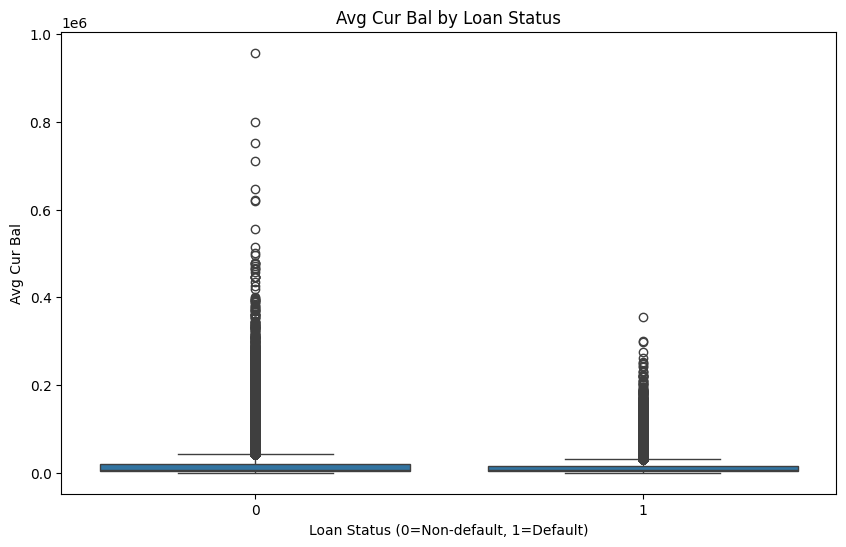

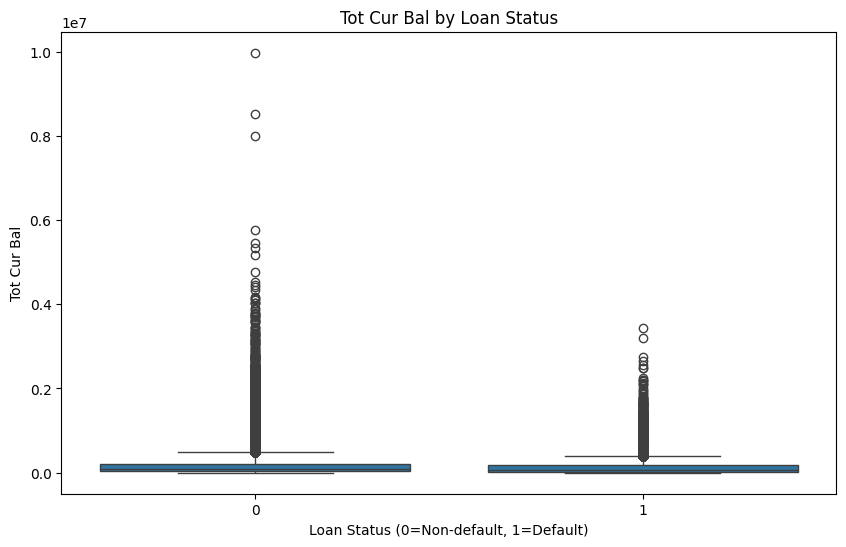

In [53]:
for col in ['revol_util', 'bc_util']:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='loan_status_binary', y=col, data=df1)
    plt.title(f'{col.replace("_", " ").title()} by Loan Status')
    plt.xlabel('Loan Status (0=Non-default, 1=Default)')
    plt.ylabel(col.replace("_", " ").title())
    plt.show()

for col in ['open_acc', 'total_acc', 'avg_cur_bal', 'tot_cur_bal']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='loan_status_binary', y=col, data=df1)
    plt.title(f'{col.replace("_", " ").title()} by Loan Status')
    plt.xlabel('Loan Status (0=Non-default, 1=Default)')
    plt.ylabel(col.replace("_", " ").title())
    plt.show()


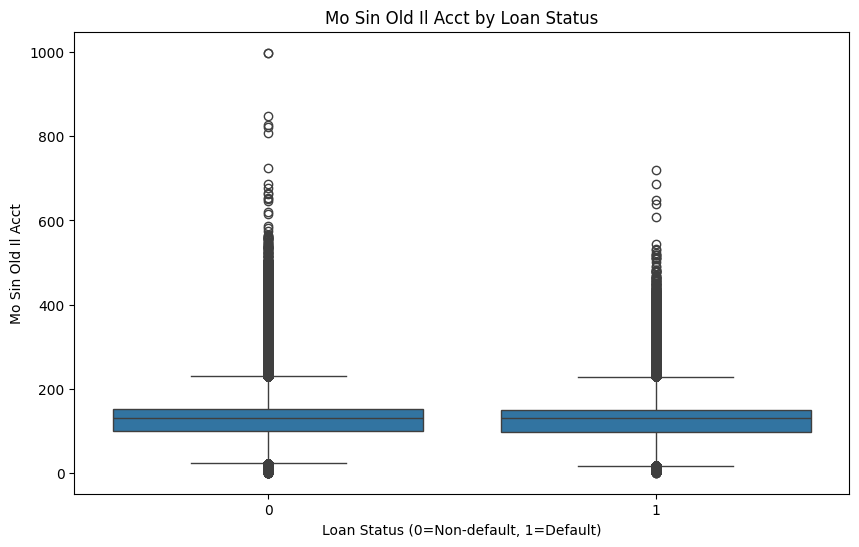

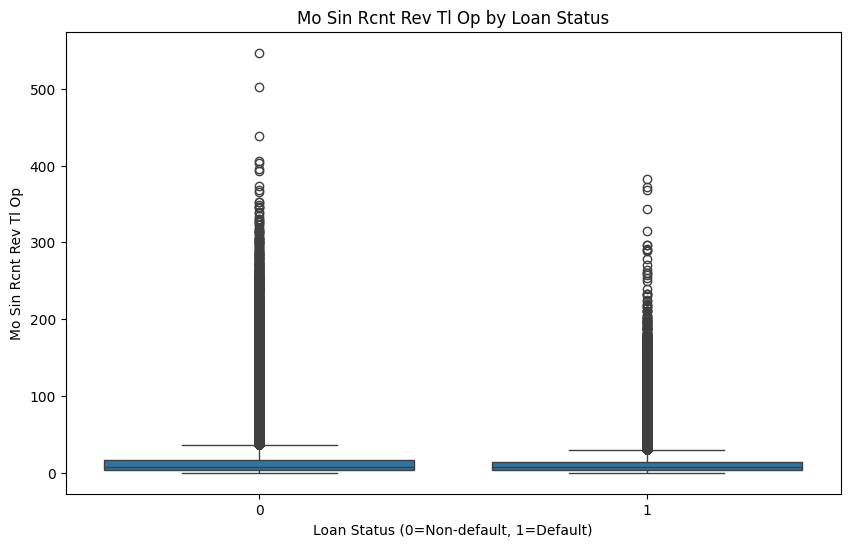

In [54]:
for col in ['mo_sin_old_il_acct', 'mo_sin_rcnt_rev_tl_op']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='loan_status_binary', y=col, data=df1)
    plt.title(f'{col.replace("_", " ").title()} by Loan Status')
    plt.xlabel('Loan Status (0=Non-default, 1=Default)')
    plt.ylabel(col.replace("_", " ").title())
    plt.show()


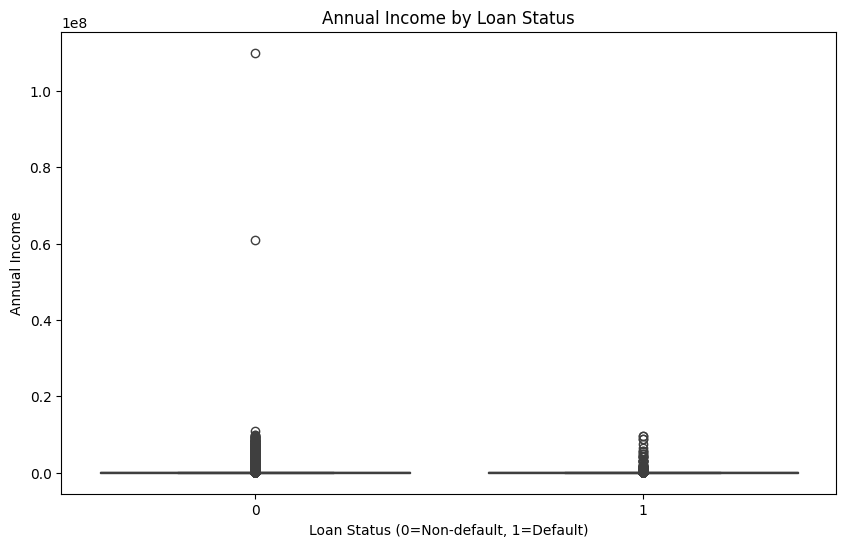

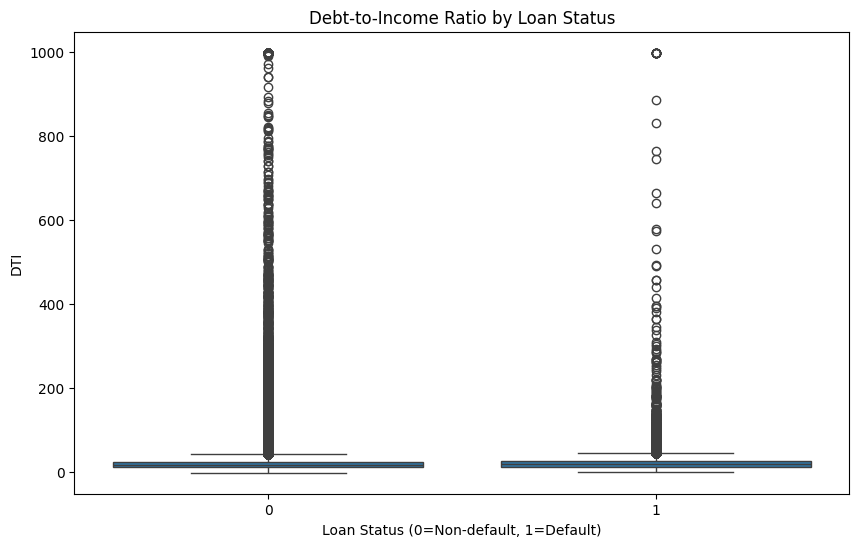

In [55]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status_binary', y='annual_inc', data=df1)
plt.title('Annual Income by Loan Status')
plt.xlabel('Loan Status (0=Non-default, 1=Default)')
plt.ylabel('Annual Income')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status_binary', y='dti', data=df1)
plt.title('Debt-to-Income Ratio by Loan Status')
plt.xlabel('Loan Status (0=Non-default, 1=Default)')
plt.ylabel('DTI')
plt.show()


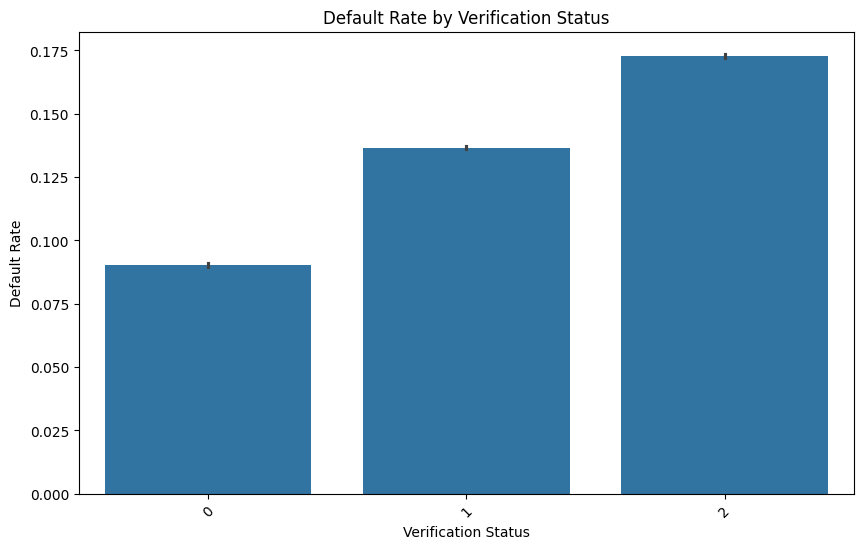

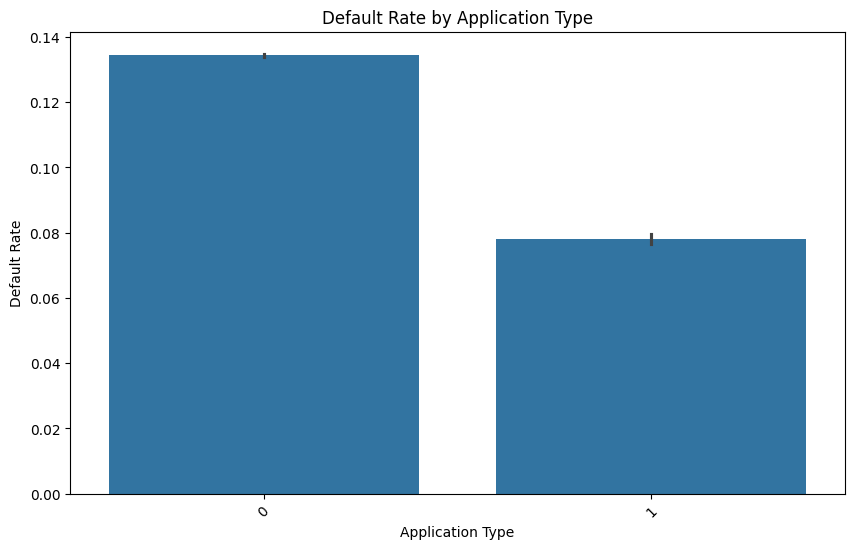

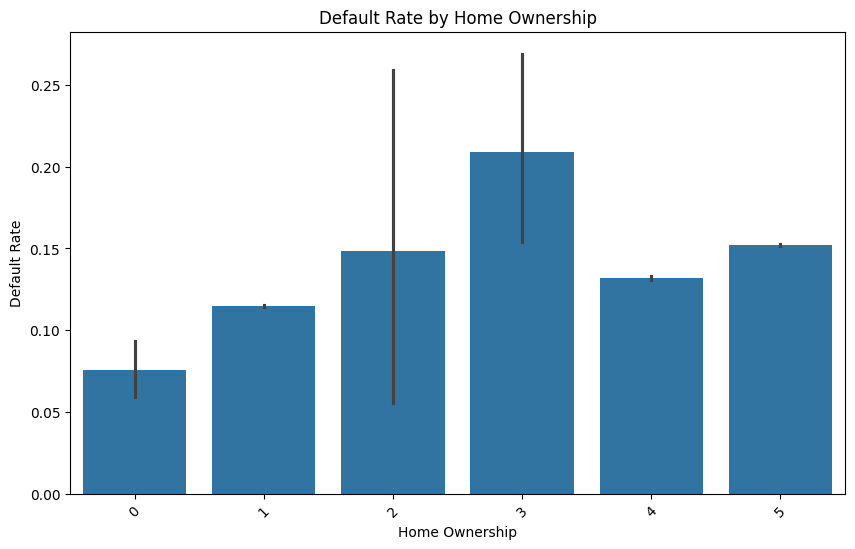

In [56]:
for col in ['verification_status', 'application_type', 'home_ownership']:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=col, y='loan_status_binary', data=df1)
    plt.title(f'Default Rate by {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Default Rate')
    plt.xticks(rotation=45)
    plt.show()


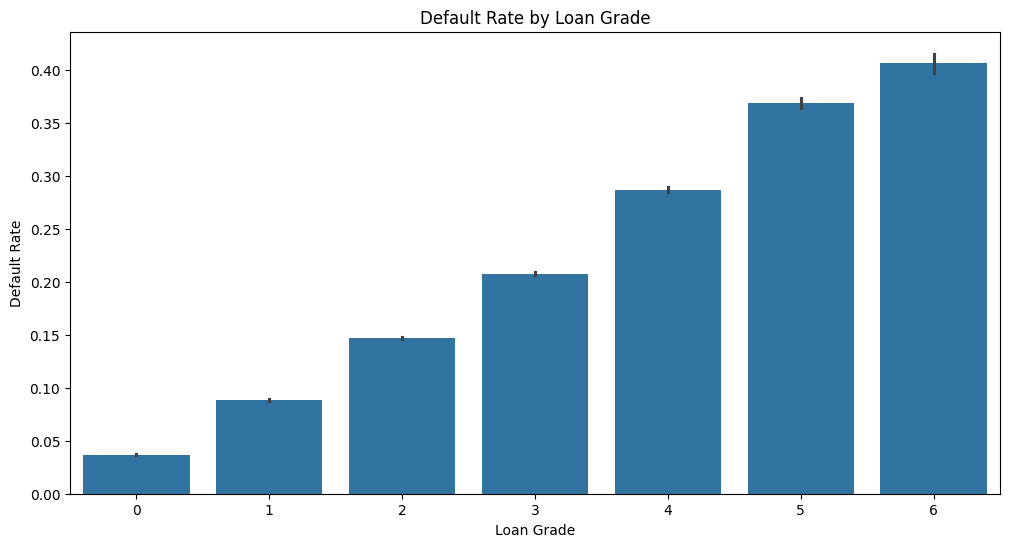

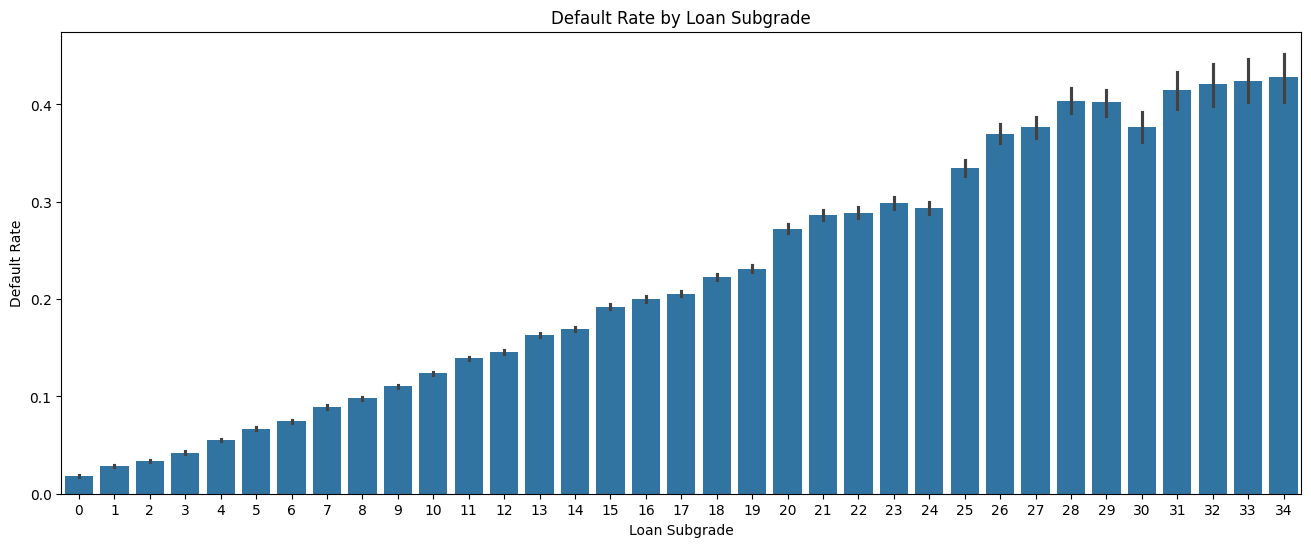

In [57]:
plt.figure(figsize=(12, 6))
sns.barplot(x='grade', y='loan_status_binary', data=df1, order=sorted(df1['grade'].unique()))
plt.title('Default Rate by Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Default Rate')
plt.show()

plt.figure(figsize=(16, 6))
sns.barplot(x='sub_grade', y='loan_status_binary', data=df1, order=sorted(df1['sub_grade'].unique()))
plt.title('Default Rate by Loan Subgrade')
plt.xlabel('Loan Subgrade')
plt.ylabel('Default Rate')
plt.show()


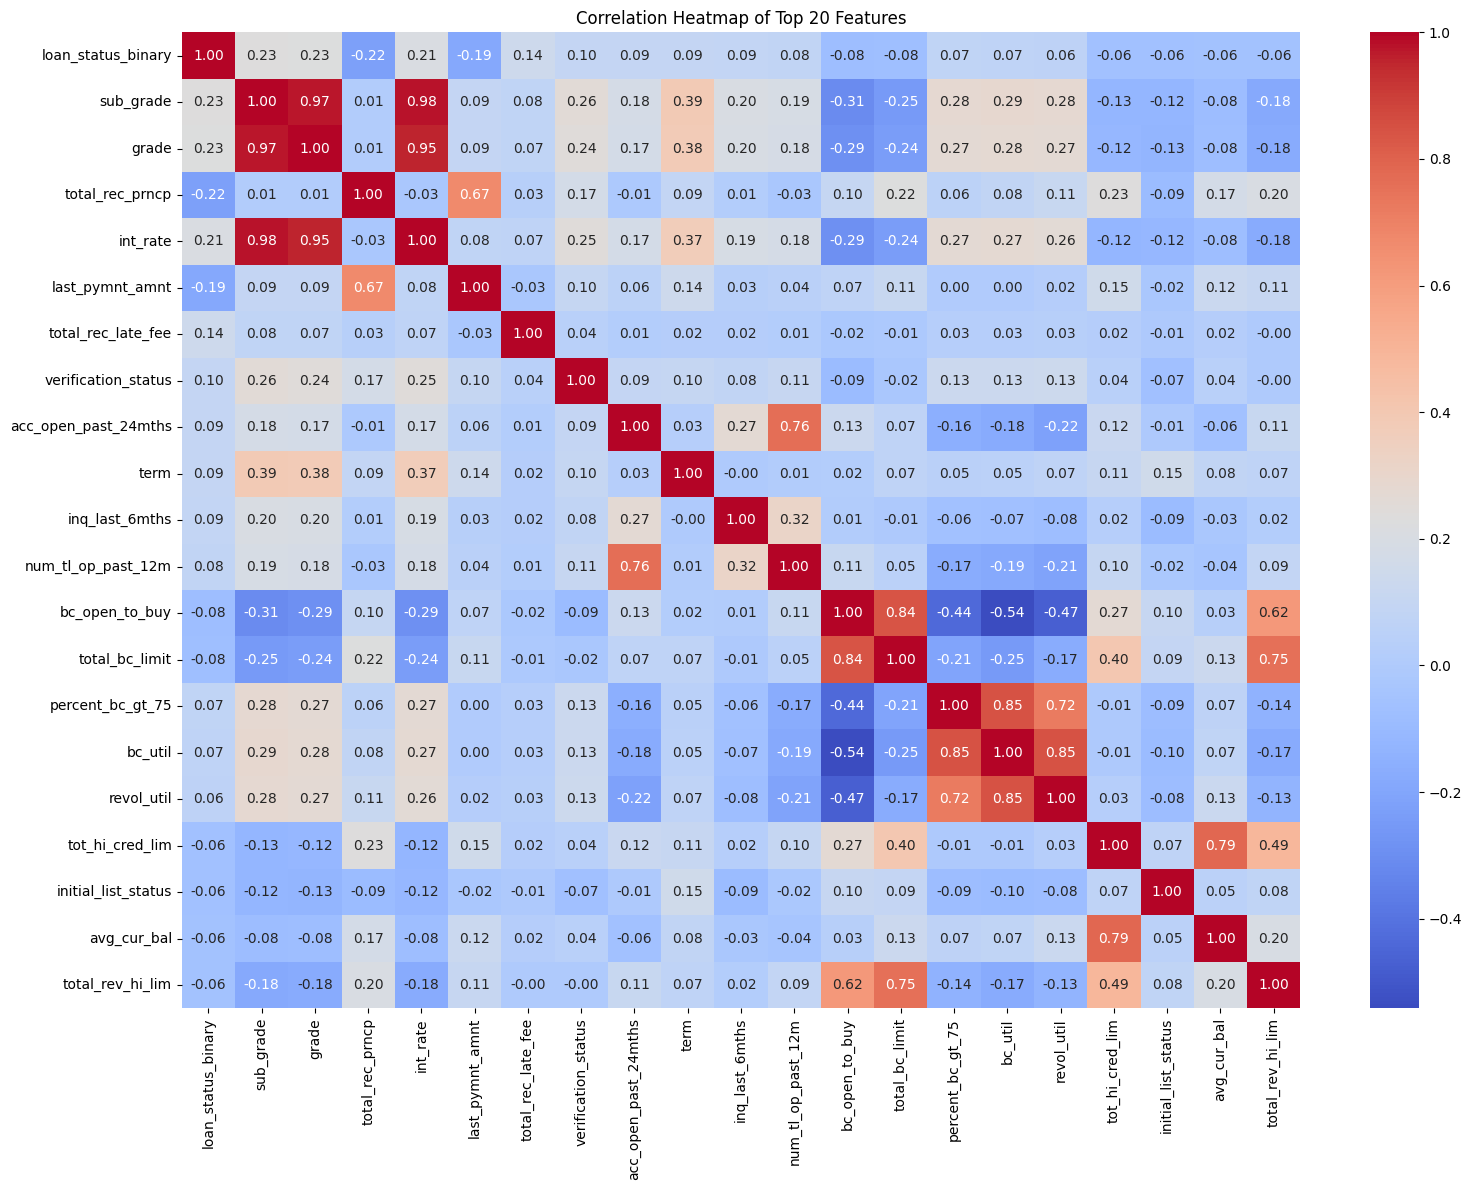

In [ ]:
corr_with_target = df1.corr(numeric_only=True)['loan_status_binary'].abs().sort_values(ascending=False)
top_features = corr_with_target.index[0:21]  # Excluding loan_status_binary itself

plt.figure(figsize=(16, 12))
sns.heatmap(df1[top_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Top 20 Features')
plt.tight_layout()
plt.show()


In [ ]:
# checking if there are any columns with non-numeric data types
non_numeric_cols = df1.select_dtypes(exclude=np.number).columns.tolist()

print("Columns with non-numeric data types:")
if non_numeric_cols:
    print(non_numeric_cols)
else:
    print("All columns are numeric.")

Columns with non-numeric data types:
All columns are numeric.


6. Outlier Detection and Treatment


In [ ]:
#key features for outlier analysis based on asset quality importance
outlier_features = [
    'loan_amnt', 'annual_inc', 'dti', 'revol_util', 'revol_bal',
    'int_rate', 'installment', 'total_acc', 'open_acc', 'bc_util',
    'tot_hi_cred_lim', 'total_bc_limit', 'avg_cur_bal'
]

# filtering columns
outlier_features = [col for col in outlier_features if col in df1.columns]
print(f"Analyzing outliers in {len(outlier_features)} key features")

#Calculating IQR-based outlier bounds
outlier_stats = {}
for col in outlier_features:
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((df1[col] < lower_bound) | (df1[col] > upper_bound)).sum()
    outlier_pct = (outliers / len(df1)) * 100

    outlier_stats[col] = {
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outlier_count': outliers,
        'outlier_pct': outlier_pct
    }

outlier_summary = pd.DataFrame(outlier_stats).T
print("Outlier Analysis Summary:")
print(outlier_summary[['outlier_count', 'outlier_pct']].sort_values('outlier_pct', ascending=False))


Analyzing outliers in 13 key features
Outlier Analysis Summary:
                 outlier_count  outlier_pct
revol_bal             137095.0     6.064358
total_bc_limit        136560.0     6.040692
avg_cur_bal           128235.0     5.672438
annual_inc            110041.0     4.867632
open_acc               84754.0     3.749069
tot_hi_cred_lim        83646.0     3.700057
installment            66312.0     2.933292
int_rate               41100.0     1.818047
total_acc              39411.0     1.743334
loan_amnt              35215.0     1.557725
dti                    21633.0     0.956930
revol_util               119.0     0.005264
bc_util                   94.0     0.004158


In [ ]:
#outlier impact on default rates
outlier_impact = {}
for col in outlier_features:
    #outlier flag
    is_outlier = ((df1[col] < outlier_stats[col]['lower_bound']) |
                  (df1[col] > outlier_stats[col]['upper_bound']))

    # default rates
    normal_default = df1[~is_outlier]['loan_status_binary'].mean()
    outlier_default = df1[is_outlier]['loan_status_binary'].mean()

    outlier_impact[col] = {
        'normal_default': normal_default,
        'outlier_default': outlier_default,
        'impact': outlier_default - normal_default
    }

# Sorting by impact magnitude
impact_df = pd.DataFrame(outlier_impact).T
impact_df = impact_df.reindex(impact_df['impact'].abs().sort_values(ascending=False).index)
print("\nOutlier Impact on Default Rates:")
print(impact_df)

# High-risk outliers (preserve with flags)
high_risk_cols = ['int_rate', 'revol_util', 'bc_util', 'dti']
for col in high_risk_cols:
    if col in df1.columns:
        # Create outlier flag to preserve information
        df1[f'{col}_outlier'] = ((df1[col] < outlier_stats[col]['lower_bound']) |
                               (df1[col] > outlier_stats[col]['upper_bound'])).astype(int)

# Low-risk outliers (winsorize)
low_risk_cols = ['loan_amnt', 'annual_inc', 'total_acc', 'avg_cur_bal']
for col in low_risk_cols:
    if col in df1.columns:
        # Cap at 1st and 99th percentiles
        p1, p99 = df1[col].quantile([0.01, 0.99])
        df1[f'{col}_capped'] = df1[col].clip(lower=p1, upper=p99)

print("Outlier treatment completed")





Outlier Impact on Default Rates:
                 normal_default  outlier_default    impact
int_rate               0.128410         0.292433  0.164023
revol_util             0.131383         0.294118  0.162735
bc_util                0.131386         0.265957  0.134571
loan_amnt              0.132479         0.062672 -0.069807
total_bc_limit         0.135297         0.070650 -0.064647
tot_hi_cred_lim        0.133508         0.076310 -0.057198
avg_cur_bal            0.134399         0.081390 -0.053009
annual_inc             0.133508         0.090039 -0.043468
dti                    0.131726         0.096797 -0.034929
revol_bal              0.133312         0.101645 -0.031667
total_acc              0.131132         0.146051  0.014919
open_acc               0.131021         0.140914  0.009893
installment            0.131177         0.138482  0.007304
Outlier treatment completed


In [62]:
# High-risk features – preserve extreme values, just cap at IQR bounds
high_risk_cols = ['int_rate', 'revol_util', 'bc_util', 'dti']
high_risk_cols = [col for col in high_risk_cols if col in df1.columns]

for col in high_risk_cols:
    lb = outlier_stats[col]['lower_bound']
    ub = outlier_stats[col]['upper_bound']
    df1[col] = df1[col].clip(lower=lb, upper=ub)

# Low-risk features – winsorize at 1st and 99th percentiles
low_risk_cols = ['loan_amnt', 'annual_inc', 'total_acc', 'avg_cur_bal']
low_risk_cols = [col for col in low_risk_cols if col in df1.columns]

for col in low_risk_cols:
    p1, p99 = df1[col].quantile([0.01, 0.99])
    df1[col] = df1[col].clip(lower=p1, upper=p99)

print("✅ Outliers capped in-place based on feature risk profile.")



✅ Outliers capped in-place based on feature risk profile.


In [64]:
df1.shape

(2260668, 67)

7. Feature Engineering

In [ ]:
# 1. Payment capacity ratios
df1['payment_burden'] = df1['installment'] / (df1['annual_inc'] / 12)
df1['loan_income_ratio'] = df1['loan_amnt'] / df1['annual_inc']

# 2. Credit utilization ratio
df1['utilization_ratio'] = df1['revol_bal'] / (df1['total_rev_hi_lim'] + 1)

# 3. Account management ratio
df1['active_account_ratio'] = df1['open_acc'] / df1['total_acc']

# 4. Risk flag count
df1['risk_flag_count'] = (
    (df1['dti'] > 25).astype(int) +
    (df1['revol_util'] > 75).astype(int) +
    (df1['delinq_2yrs'] > 0).astype(int)
)

# 5. Delinquency score
df1['delinquency_score'] = df1['delinq_2yrs'] + df1['pub_rec'] + df1['pub_rec_bankruptcies']

# 6. Credit quality score (assuming grade is numeric-encoded already)
df1['credit_quality'] = 100 - (df1['grade'] * 10)

# # 7. Scaled scores (0 to 100, where higher is better)
# df1['payment_burden_scaled'] = 100 - (df1['payment_burden'] / df1['payment_burden'].max() * 100).clip(0, 100)
# df1['utilization_ratio_scaled'] = 100 - (df1['utilization_ratio'] / df1['utilization_ratio'].max() * 100).clip(0, 100)
# df1['delinquency_score_scaled'] = 100 - (df1['delinquency_score'] / df1['delinquency_score'].max() * 100).clip(0, 100)

# # 8. Composite asset quality score using selected scaled features
# df1['asset_quality_score'] = (
#     0.4 * df1['credit_quality'] +
#     0.3 * df1['payment_burden_scaled'] +
#     0.3 * df1['utilization_ratio_scaled']
# ).clip(0, 100)

# # 9. Asset quality summary
# print("\nAsset Quality Score by Loan Status:")
# print(df1.groupby('loan_status_binary')['asset_quality_score'].agg(['mean', 'std', 'count']))

# print(f"\nAsset Quality Score correlation with default: {df1['asset_quality_score'].corr(df1['loan_status_binary']):.4f}")

# # 10. Summary of new features created
# print(f"\nFinal dataset shape: {df1.shape}")
# print("New features created:")
# print([
#     'payment_burden', 'loan_income_ratio', 'utilization_ratio', 'active_account_ratio',
#     'risk_flag_count', 'delinquency_score', 'credit_quality',
#     'payment_burden_scaled', 'utilization_ratio_scaled', 'delinquency_score_scaled',
#     'asset_quality_score'
# ])

In [3]:
import pandas as pd

preprocessed_file = 'C:\\Users\\Admin\\asset_quality_score\\data\\processed\\processed_loan_csv.csv'
df1 = pd.read_csv(preprocessed_file)

columns_to_drop = [
    'asset_quality_score', 
    'payment_burden_scaled', 
    'utilization_ratio_scaled', 
    'delinquency_score_scaled'
]

df1.drop(columns=[col for col in columns_to_drop if col in df1.columns], inplace=True)

In [4]:
df1.shape

(1257758, 74)

In [ ]:
#output path
output_path = 'C:\\Users\\Admin\\asset_quality_score\\data\\processed\\processed_loan_csv.csv'

# Saving Dataframe
df1.to_csv(output_path, index=False)

print("✅ File saved successfully at:", output_path)


✅ File saved successfully at: C:\Users\Admin\asset_quality_score\data\processed\processed_loan_csv.csv
